# ROI detection with Deep Learning
Notebook used to test ROI detection using PyTorch

In [2]:
% matplotlib inline

import os, time
import random

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image

import torch
import torchvision
from torch.utils import data

from utils_common.ROI_detection import imread_to_float, dice_coef, loss_mae
from utils_data import ImageLoaderDataset, normalize_symmetric_range, get_filenames, get_dataloaders
from utils_model import weights_initialization, CustomNet
from utils_train import train
from utils_test import predict, evaluate, show_sample

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

%load_ext autoreload
%autoreload 2

## Parameters
Hyperparameters, folder names, etc.

In [2]:
train_ratio = 0.8 # percentage going to training, rest to validation
n_epochs = 50
batch_size = 32
learning_rate = 0.001
input_channels = "RG" # Channel to use as input

model_name = "test"
model_dir = "models/"
data_dir = "dataset/"

## Data loading
Load data into tensors, and/or create dataloaders.

In [3]:
# Create lists of filenames
x_filenames, y_filenames = get_filenames(data_dir)

# Create dataloaders
train_loader, valid_loader = get_dataloaders(x_filenames, y_filenames, train_ratio, batch_size,
                                             input_channels=input_channels,
                                             train_transform=None, 
                                             valid_transform=None)

N_TRAIN = len(train_loader.dataset)
N_VALID = len(valid_loader.dataset)
N_SAMPLES = N_TRAIN + N_VALID
HEIGHT, WIDTH = io.imread(x_filenames[0]).shape[:2]
print("%d images found (%d to train, %d to validation), of size %dx%d." % \
      (N_SAMPLES, N_TRAIN, N_VALID, HEIGHT, WIDTH))

# Compute class weights (as pixel imbalance)
pos_count = 0
neg_count = 0
for _, batch_y in train_loader:
    pos_count += (batch_y == 1).sum().item()
    neg_count += (batch_y == 0).sum().item()
pos_weight = torch.tensor(neg_count / pos_count)
print("{} ROI pixels, and {} background --> {:.3f} positive weighting.".format(
    pos_count, neg_count, pos_weight.item()))

600 images found (480 to train, 120 to validation), of size 192x256.
225912 ROI pixels, and 23367048 background --> 103.434 positive weighting.


## Model definition
Define model, loss, and optimizer.

In [4]:
model = CustomNet((HEIGHT, WIDTH, len(input_channels)))

loss_fn = torch.nn.BCEWithLogitsLoss(reduction='elementwise_mean', pos_weight=pos_weight)

dice_metric = lambda preds, targets: torch.tensor(dice_coef((torch.sigmoid(preds) > 0.5).detach().numpy(),
                                                            targets.detach().numpy()))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [5]:
best_model, history = train(model,
                            {"train": train_loader, "valid": valid_loader},
                            loss_fn,
                            optimizer,
                            n_epochs,
                            metrics = {"dice": dice_metric},
                            criterion_metric = "dice",
                            model_dir = os.path.join(model_dir, model_name),
                            replace_dir = True,
                            verbose = 1)

Epoch 1/50  (Elapsed time: 0h 00min 00s)
----------------------------------------
Batch (over 15): 1...
Train loss: 0.016526 - dice: 0.016526
Valid loss: 0.015506 - dice: 0.015506

Epoch 2/50  (Elapsed time: 0h 00min 02s)
----------------------------------------
Batch (over 15): 1...
Train loss: 0.019770 - dice: 0.019770
Valid loss: 0.020997 - dice: 0.020997

Epoch 3/50  (Elapsed time: 0h 00min 05s)
----------------------------------------
Batch (over 15): 1...
Train loss: 0.023530 - dice: 0.023530
Valid loss: 0.028597 - dice: 0.028597

Epoch 4/50  (Elapsed time: 0h 00min 07s)
----------------------------------------
Batch (over 15): 1...
Train loss: 0.028271 - dice: 0.028271
Valid loss: 0.035523 - dice: 0.035523

Epoch 5/50  (Elapsed time: 0h 00min 09s)
----------------------------------------
Batch (over 15): 1...
Train loss: 0.034771 - dice: 0.034771
Valid loss: 0.042766 - dice: 0.042766

Epoch 6/50  (Elapsed time: 0h 00min 11s)
----------------------------------------
Batch (over 1

Batch (over 15): 1...
Train loss: 0.288106 - dice: 0.288106
Valid loss: 0.292736 - dice: 0.292736

Epoch 47/50  (Elapsed time: 0h 02min 18s)
-----------------------------------------
Batch (over 15): 1...
Train loss: 0.287305 - dice: 0.287305
Valid loss: 0.294760 - dice: 0.294760

Epoch 48/50  (Elapsed time: 0h 02min 21s)
-----------------------------------------
Batch (over 15): 1...
Train loss: 0.289960 - dice: 0.289960
Valid loss: 0.301174 - dice: 0.301174

Epoch 49/50  (Elapsed time: 0h 02min 24s)
-----------------------------------------
Batch (over 15): 1...
Train loss: 0.291925 - dice: 0.291925
Valid loss: 0.298014 - dice: 0.298014

Epoch 50/50  (Elapsed time: 0h 02min 28s)
-----------------------------------------
Batch (over 15): 1...
Train loss: 0.290805 - dice: 0.290805
Valid loss: 0.302742 - dice: 0.302742

Training took 0h 02min 31s.
Best validation dice = 0.303


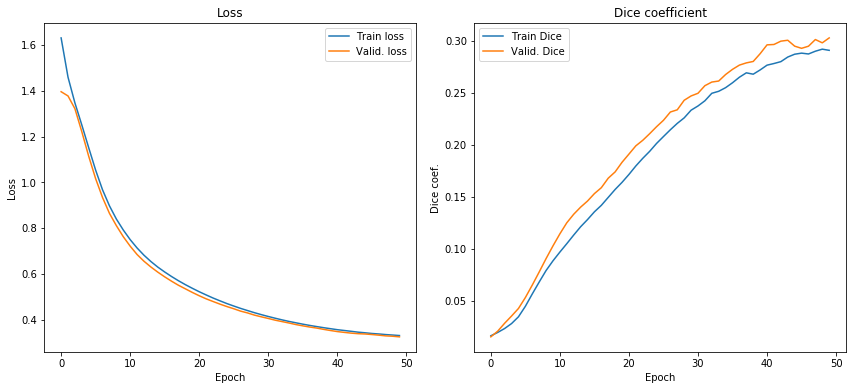

In [6]:
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Loss")
plt.plot(history["epoch"], history["loss"])
plt.plot(history["epoch"], history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train loss", "Valid. loss"])
plt.subplot(122)
plt.title("Dice coefficient")
plt.plot(history["epoch"], history["dice"])
plt.plot(history["epoch"], history["val_dice"])
plt.xlabel("Epoch")
plt.ylabel("Dice coef.")
plt.legend(["Train Dice", "Valid. Dice"])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Testing

In [7]:
# Test over validation data
valid_metrics = evaluate(best_model, valid_loader, {"loss": loss_fn, "dice": dice_metric})
print("Best model loss = {}\nDice coefficient = {}".format(valid_metrics["loss"], valid_metrics["dice"]))

Best model loss = 0.32479123075803124
Dice coefficient = 0.30274226864178977


In [8]:
#For reproducible results (seed=1, channels="RG", batch_size=32, learning_rate=0.001)
print("Best model loss = 0.32479123075803124")
print("Dice coefficient = 0.30274226864178977")

Best model loss = 0.32479123075803124
Dice coefficient = 0.30274226864178977


Image 57: dice = 0.331446; 
Image 14: dice = 0.378291; 
Image 112: dice = 0.314956; 
Image 45: dice = 0.323072; 


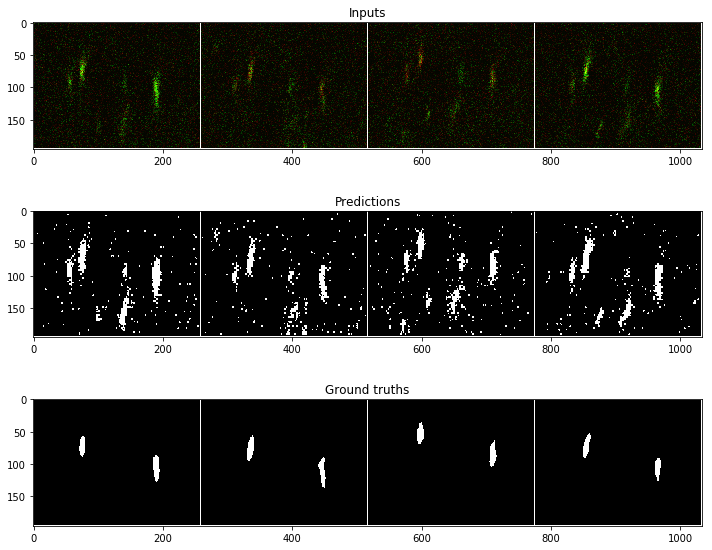

In [9]:
show_sample(best_model, valid_loader, n_samples=4, 
            post_processing = lambda preds: torch.tensor(torch.sigmoid(preds) > 0.5, dtype=torch.float32), 
            metrics = ({"dice": dice_metric}))